# SARIMA Pistoia Tourists Arrivals
This notebook calculates the SARIMA model for the total number of tourists arrivals in Pistoia.

## Getting Started
Import the dataset related to foreign tourists arrivals in Pistoia from 2012 to 2020 March and convert it into a time series. Data are extracted from the [Osservatorio Turismo Pistoia]( https://turismo5pistoia.regione.toscana.it/).

In order to perform conversion to time series, two steps are needed:
* the column containing dates must be converted to datetime. This can be done through the function `to_datetime()`, which converts a string into a datetime.
* set the index of the dataframe to the column containing dates. This can be done through the function `set_index()` applied to the dataframe.

In [1]:
import pandas as pd

df = pd.read_csv('../sources/PT_tourists_arrivals.csv')
df['date'] = pd.to_datetime(df['date'])

Then, eliminate dates before 2012-01-01. Set index of the dataframe to `date` to make the dataframe a time series.

In [2]:
df.drop('year', axis=1, inplace=True)
df.drop('month', axis=1, inplace=True)
df.set_index('date', inplace=True)
df

,arrivals
date,
2012-01-01,14751
2012-02-01,18562
2012-03-01,41478
2012-04-01,55215
2012-05-01,53843
...,...
2020-01-01,36281
2020-02-01,33587
2020-03-01,4766


In [3]:
df.describe()

,arrivals
count,101.000000
mean,61807.326733
std,27695.406300
min,307.000000
25%,37983.000000
50%,65370.000000
75%,87770.000000
max,108992.000000


## Preliminary analysis
The preliminary analysis consists into a visual analysis of the time series, in order to understand its general trend and behavior.
Firstly, we create the time series and we store it in the variable `ts`.

In [4]:
ts = df['arrivals']
ts.tail()

date
2020-01-01    36281
2020-02-01    33587
2020-03-01     4766
2020-04-01      307
2020-05-01     2490
Name: arrivals, dtype: int64

Then, we plot the `ts` trend.

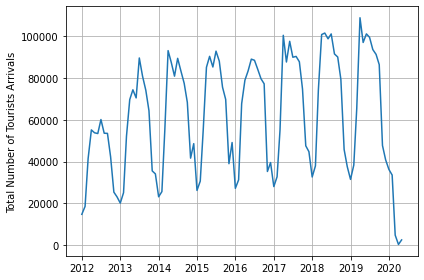

In [5]:
import matplotlib.pylab as plt
plt.plot(ts)
plt.ylabel('Total Number of Tourists Arrivals')
plt.grid()
plt.tight_layout()
plt.savefig('plots/PT_tourists_arrivals.png')
plt.show()

## Chow Test
Now we perform the Chow Test to verify the presence of a breakpoint. The Chow Test assumes to know in advance the potential breakpoint and verifies whether the breakpoint is real or not. The Chow Test models data through a linear regression and calculates three models: 
* M: the first model contains all the data
* M1: the second model contains only data before the breakpoint
* M2: the third model contains only data after the breakpoint
Then it checks whether or not the model M represents data better than M1 and M2. The Chow test returns the Chow Statistics, which indicates whether the null hypothesis is true or not. The null hypothesis is that there is no structural break. If the Chow Statistics < alpha then reject the null hypothesis, i.e. there is a break.

The code uses the function `get_rss()` to calculate the residual sum of squares of a linear model.

In [6]:
from sklearn.model_selection import train_test_split 
from sklearn import preprocessing
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

def get_rss(X,y):
    X_scaled = preprocessing.scale(X.reshape(-1,1))

    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=0)
    model = LinearRegression().fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    return [model, X_scaled, np.sum(((y_pred - y_test) ** 2))]

Now we implement the function which performs the Chow Test. The function receives `X`, `y`, the index of the break_point and a boolean which specifies if also a plot should be drawn. The function returns the Chow statistics as output.

In [7]:
def chow_test(X,y,break_point,bplot=False):
    X1, X2 = X[0:break_point+1], X[break_point:]
    y1, y2 = y[0:break_point+1], y[break_point:]
    
    model, X_scaled, rss = get_rss(X,y)
    model1, X1_scaled, rss1 = get_rss(X1,y1)
    model2, X2_scaled, rss2 = get_rss(X2,y2)

    k = len(X) + 1

    N1 = len(X1)
    # gets the number of observations in the second period
    N2 = len(X2)

    # calculates the numerator of the Chow Statistic
    numerator = (rss - (rss1 + rss2)) / k
    # calculates the denominator of the Chow Statistic
    denominator = (rss1 + rss2) / (N1 + N2 - 2 * k)
    
    # calculates the Chow Statistic
    chow_stat = numerator / denominator
    alpha = 0.05
    #print(chow_stat)
    if bplot:
        print("Potential Break Point: " + str(X[0] + break_point))
        plt.vlines(X[0] + break_point, ymin=0, ymax=max(y), linewidth=2, color='r', linestyle='--',label='breakpoint')
        plt.plot(X, y,  label='test')
        plt.plot(X, model.predict(X_scaled), color='green', linewidth=1, label='prediction')
        plt.plot(X1, model1.predict(X1_scaled), color='orange', linewidth=1, label='prediction1')
        plt.plot(X2, model2.predict(X2_scaled), color='orange', linewidth=1, label='prediction2')
        plt.legend()
        plt.ylabel('Total Number of Tourists Arrivals')
        plt.grid()
        plt.tight_layout()
        plt.savefig('plots/PT_chow_output.png')
        plt.show()
        if chow_stat < alpha: # reject null hypotesis: no break
            print("Break")
    return chow_stat

We build `X` and `y` from `ts`. In order to find all the breakpoints, we perform a recursive chow test, which returns the list of all Chow Statistics.

Now we are ready to calculate the breakpoint. We implement the function `get_breakpoint()`, which receives as input the number of elements to skip in `X` and `y` and returns the breakpoint and the associated date. The function orders by increasing p value and returns the p value with the minimum value.

The first breakpoint refers to 2019 February, which seems too far from the COVID-19 outbreak. Thus, we search a new breakpoint after that date.

Now we perform an alternative test to verify the presence of a breakpoint, i.e. the cumsum test. We use the function `breaks_cusumolsresid()` defined in the `statsmodels.stats.diagnostic` package.

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
from scipy.stats import normaltest
from matplotlib import pyplot
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.seasonal import STL

def decompose(lts,model='simple'):
    # model='multiplicative'
    decomposition = ''
    if model == 'STL':
        stl = STL(lts, seasonal=13)
        decomposition = stl.fit()
    else:
        decomposition = seasonal_decompose(lts,period=12,two_sided=True,extrapolate_trend=1,model='multiplicative')
    
    ts_trend = decomposition.trend
    ts_seasonal = decomposition.seasonal
    ts_residual = decomposition.resid
    
    plt.subplot(411)
    plt.plot(lts,label='original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(ts_trend,label='trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(ts_seasonal,label='seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(ts_residual,label='residual')
    plt.legend(loc='best')
    plt.tight_layout()
    plt.savefig('plots/PT_tourists_arrivals_decomp.png')
    plt.show()
    
    
    statistic, pvalue = normaltest(ts_residual.dropna())
    
    pyplot.hist(ts_residual.dropna())
    qqplot(ts_residual, line='s')
    pyplot.show()
    
    alpha = 0.05
    if pvalue < alpha :  
        print("X does not follow a normal distribution with pvalue = " + str(pvalue))
        
    else:
        print("X follows a normal distribution with pvalue = " + str(pvalue))
        
    return ts_trend,ts_seasonal,ts_residual

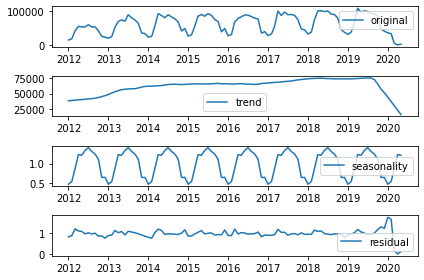

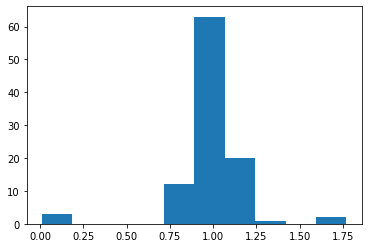

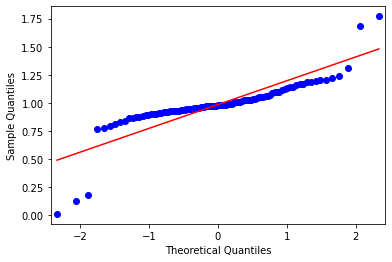

X does not follow a normal distribution with pvalue = 4.996117497970542e-11


In [9]:
ts_trend, ts_seasonal, ts_residual = decompose(ts)

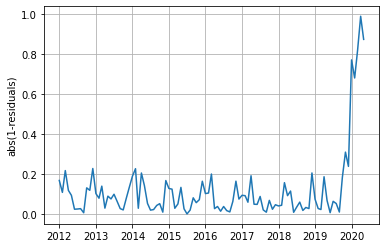

[94, Timestamp('2019-11-01 00:00:00')]

In [10]:
abs_resid = np.abs(1-ts_residual)
plt.plot(abs_resid)
plt.ylabel('abs(1-residuals)')
plt.grid()
plt.savefig('plots/PT_residuals.png')
plt.show()
bp = 0
for i in range(0, len(abs_resid)):
    if abs_resid.values[i] > 0.3:
        bp = [i, abs_resid.index[i]]
        break
bp

Potential Break Point: 94


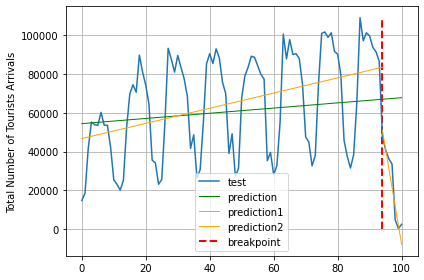

Break


-0.14663290777052376

In [11]:
X = np.arange(0,len(ts))
y = np.array(ts.values)
chow_test(X,y,bp[0],bplot=True)


In [12]:
import statsmodels.api as sm
from statsmodels.stats.diagnostic import breaks_cusumolsresid
X_res = np.arange(0,len(ts_residual))
y_res = np.array(ts_residual.values)

model = sm.OLS(y_res, X_res)
results = model.fit()
stat = breaks_cusumolsresid(results.resid, ddof=results.df_model)
alpha = stat[2][0][1] # alpha 1%
if stat[1] < alpha: #reject null hypothesis (null hypothesis = no break)
    print("Break")
else:
    print("No break")
print(stat[1])

Break
3.049526737907555e-33


Now we can split the time series into two parts: `tsb` (ts before), which contains the time series before the break, and `tsa` (ts after), which contains the time series after the break.

In [13]:
tsb = ts[:-len(ts)+bp[0]]
tsa = ts[-len(ts)+bp[0]:]
tsa

date
2019-11-01    47747
2019-12-01    40886
2020-01-01    36281
2020-02-01    33587
2020-03-01     4766
2020-04-01      307
2020-05-01     2490
Name: arrivals, dtype: int64

Decomopose the time series in three parts: trend, seasonality and residuals.

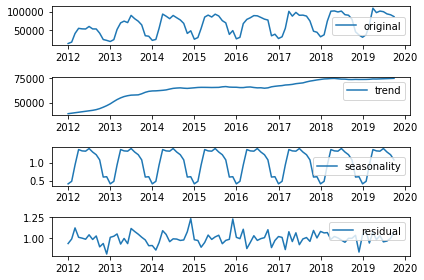

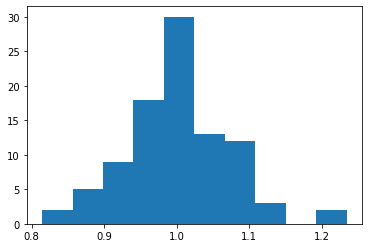

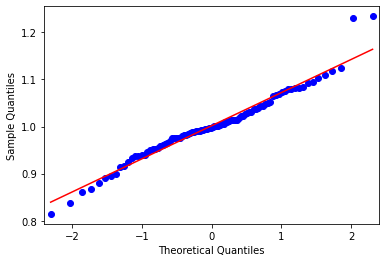

X does not follow a normal distribution with pvalue = 0.023009552674815047


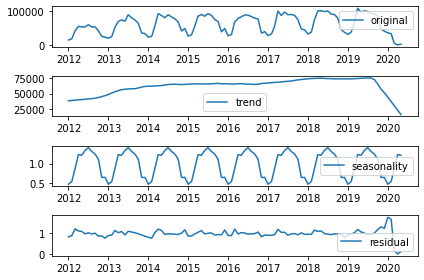

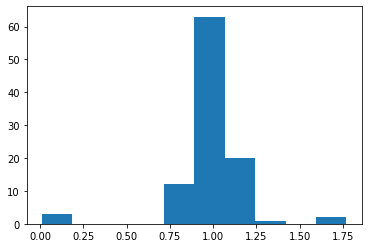

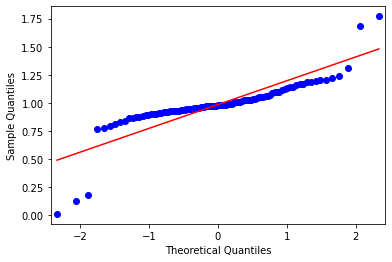

X does not follow a normal distribution with pvalue = 4.996117497970542e-11


In [14]:
tsb_diff = tsb.diff(periods=12).dropna()
#ts_diff_shifted
#tsb_diff = tsb.diff().dropna()
#min_tsb_diff = np.abs(np.min(tsb_diff))
#tsb_diff_shifted = ts_diff + min_tsb_diff + 1
ts_diff = ts.diff(periods=12).dropna()
tsb_trend, tsb_seasonal, tsb_residual = decompose(tsb)
ts_trend, ts_seasonal, ts_residual = decompose(ts)
tsa_trend = ts_trend[-len(ts)+bp[0]:]
tsa_seasonal = ts_seasonal[-len(ts)+bp[0]:]
tsa_residual = ts_residual[-len(ts)+bp[0]:]

In [15]:
print(np.std(tsb_residual))
print(np.mean(tsb_residual))

0.07031146589005194
1.0016773288580143


## Build the model

### SARIMA Model
SARIMA is an acronym for Seasonal AutoRegressive Integrated Moving Average. It is composed of two models AR and MA. The model is defined by three parameters:
* p = order of the AR part
* d = degree of first differencing involved
* q = order of the moving average part.

The value of p can be determined through the ACF plot, which shows the autocorrelations which measure the relationship between an observation and its previous one.

The value of q can be determined through the PACF plot.

In [16]:
from statsmodels.tsa.stattools import adfuller

def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    #Plot rolling statistics:
    plt.plot(timeseries, color='blue',label='Original')
    plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.grid()
    plt.show()
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    
    critical_value = dftest[4]['5%']
    test_statistic = dftest[0]
    alpha = 1e-3
    pvalue = dftest[1]
    if pvalue < alpha and test_statistic < critical_value:  # null hypothesis: x is non stationary
        print("X is stationary")
        return True
    else:
        print("X is not stationary")
        return False

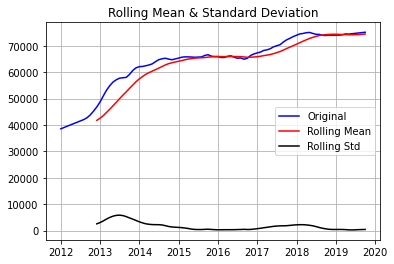

Results of Dickey-Fuller Test:
Test Statistic                 -3.519131
p-value                         0.007509
#Lags Used                      8.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64
X is not stationary


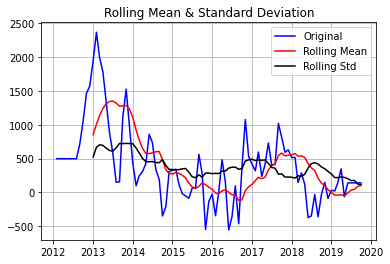

Results of Dickey-Fuller Test:
Test Statistic                 -2.117205
p-value                         0.237653
#Lags Used                      7.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64
X is not stationary


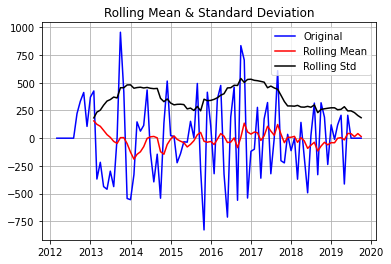

Results of Dickey-Fuller Test:
Test Statistic                 -3.720266
p-value                         0.003837
#Lags Used                      6.000000
Number of Observations Used    85.000000
Critical Value (1%)            -3.509736
Critical Value (5%)            -2.896195
Critical Value (10%)           -2.585258
dtype: float64
X is not stationary


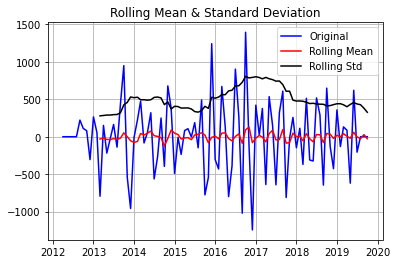

Results of Dickey-Fuller Test:
Test Statistic                 -5.044896
p-value                         0.000018
#Lags Used                     11.000000
Number of Observations Used    79.000000
Critical Value (1%)            -3.515977
Critical Value (5%)            -2.898886
Critical Value (10%)           -2.586694
dtype: float64
X is stationary


In [17]:
tsb_diff = pd.Series(tsb_trend)
d = 0
while test_stationarity(tsb_diff) is False:
    tsb_diff = tsb_diff.diff().dropna()
    d = d + 1

In [18]:
d

3

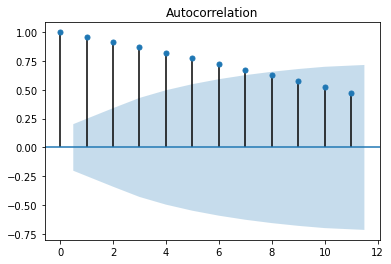

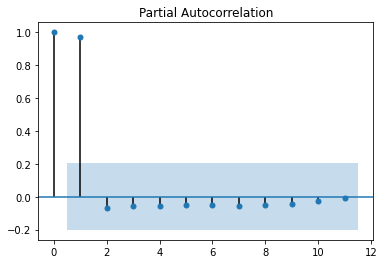

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_acf(tsb_trend, lags =11)
plot_pacf(tsb_trend, lags =11)
plt.show()

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:159: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  warnings.warn('No frequency information was'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:975: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/statsmodels/base/model.py:567: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warn("Maximum Like

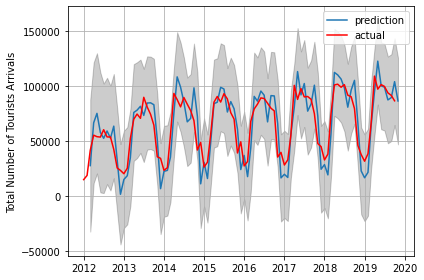

In [20]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

size = 5*12
train, test = tsb_trend[0:size], tsb_trend[size:]
# 1,1,2
p = 2
q = 7
model = SARIMAX(tsb, order=(p,d,q))
model_fit = model.fit(disp=1,solver='powell')
    
#tsb_trend_p = model_fit.predict(start=1, end=len(tsb_trend)+4)
fcast = model_fit.get_prediction(start=1, end=len(tsb))
tsb_trend_p = fcast.predicted_mean

tsb_trend_ci = fcast.conf_int()


plt.show()
plt.plot(tsb_trend_p[1:],label='prediction')
plt.plot(tsb,color='red',label='actual')
plt.fill_between(tsb_trend_ci.index[1:],
                tsb_trend_ci.iloc[1:, 0],
                tsb_trend_ci.iloc[1:, 1], color='k', alpha=.2)

plt.ylabel('Total Number of Tourists Arrivals')
plt.legend()
plt.tight_layout()
plt.grid()
plt.savefig('plots/PT_trend_prediction.png')
plt.show()

In the ACF plot the last large spike is  at lag 12. Thus, the max value for `p = 6`. PACF and the max value of `q = 12`, because there is not a specific behavior in PACF. You can give a look [here](https://machinelearningmastery.com/tune-arima-parameters-python/) for more details.

Now we can search for the best model. We save only the model for which residuals follow a normal distribution.

Look [here](https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/) for more details about auto_arima.

In [21]:
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  
            'corr':corr, 'minmax':minmax})

In [22]:
forecast_accuracy(tsb_trend_p[2:], tsb_trend[2:])

{'mape': 0.4143723484365676,
 'me': 1628.7816545723765,
 'mae': 26436.473185887167,
 'mpe': 0.030953474733313027,
 'rmse': 30263.17476624314,
 'corr': 0.27899038367956663,
 'minmax': 0.3475597768013443}

In [23]:
from scipy import stats
stats.pearsonr(tsb_trend_p[1:], tsb[1:]) 

(0.8824316994378291, 1.4864779785772654e-31)

In [24]:
residuals = tsb - tsb_trend_p
ss_res = np.sum(residuals**2)
ss_tot = np.sum((y-np.mean(y))**2)
r_squared = 1 - (ss_res / ss_tot)
r_squared

0.7101595547396453

## Bibliography
* [A Visual Guide to Time Series Decomposition Analysis](https://medium.com/better-programming/a-visual-guide-to-time-series-decomposition-analysis-a1472bb9c930)
* [An example of time series](https://github.com/arshren/TimeSeries/blob/master/Stock%20Price%20APPL.ipynb)
* [ARIMA Model Python Example — Time Series Forecasting](https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7)
* [ARIMA model to forecast international tourist visit
in Bumthang, Bhutan](https://iopscience.iop.org/article/10.1088/1742-6596/1039/1/012023/pdf)
* [Augmented Dickey-Fuller Test in Python](http://www.insightsbot.com/augmented-dickey-fuller-test-in-python/)
* [Auto ARIMA using Pyramid ARIMA Python Package](https://datafai.com/auto-arima-using-pyramid-arima-python-package/)
* [Confidence Interval for t-test (difference between means) in Python](https://stackoverflow.com/questions/31768464/confidence-interval-for-t-test-difference-between-means-in-python)
* [Extracting Seasonality and Trend from Data: Decomposition Using R](https://anomaly.io/seasonal-trend-decomposition-in-r/index.html)
* [How to Create an ARIMA Model for Time Series Forecasting in Python](https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/)
* [How can I make a time-series stationary?](https://www.researchgate.net/post/How_can_I_make_a_time-series_stationary)
* [How to Remove Trends and Seasonality with a Difference Transform in Python](https://machinelearningmastery.com/remove-trends-seasonality-difference-transform-python/)
* [How to Tune ARIMA Parameters in Python](https://machinelearningmastery.com/tune-arima-parameters-python/)
* [Non-seasonal ARIMA models](https://otexts.com/fpp2/non-seasonal-arima.html)
* [Interpret the partial autocorrelation function (PACF)](https://support.minitab.com/en-us/minitab/18/help-and-how-to/modeling-statistics/time-series/how-to/partial-autocorrelation/interpret-the-results/partial-autocorrelation-function-pacf/)
* [Stationarity testing using the Augmented Dickey-Fuller test](https://medium.com/wwblog/stationarity-testing-using-the-augmented-dickey-fuller-test-8cf7f34f4844)
* [The signal and the noise](http://people.fisica.uniroma2.it/~solare/en/wp-content/uploads/2018/12/Lez_12_Noises.pdf)
* [Time Series Decomposition](http://course1.winona.edu/bdeppa/FIN%20335/Handouts/Time_Series_Decomposition.html#multiplicative-decomposition)
* [Time Series Forecast : A basic introduction using Python.](https://medium.com/@stallonejacob/time-series-forecast-a-basic-introduction-using-python-414fcb963000)
* [Time Series Analysis in Python – A Comprehensive Guide with Examples](https://www.machinelearningplus.com/time-series/time-series-analysis-python/)
* [Time Series Forecast Case Study with Python: Monthly Armed Robberies in Boston](https://machinelearningmastery.com/time-series-forecast-case-study-python-monthly-armed-robberies-boston/)
* [Time Series prediction using SARIMAX](https://medium.com/datadriveninvestor/time-series-prediction-using-sarimax-a6604f258c56)
* [Understand ARIMA and tune P, D, Q](https://www.kaggle.com/sumi25/understand-arima-and-tune-p-d-q)

### Breakpoint Test
* [A Survey of Methods for Time Series Change Point Detection](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5464762/)
* [Building the Python chow_test Package](https://joshualoong.com/2018/01/05/Building-the-Python-chow-test-Package/)
* [Chow Test: Definition & Examples](https://www.statisticshowto.com/chow-test/)
*[cusumolsresid](https://www.statsmodels.org/dev/generated/statsmodels.stats.diagnostic.breaks_cusumolsresid.html#statsmodels.stats.diagnostic.breaks_cusumolsresid)
* [How can I do test wald in Python?](https://stackoverflow.com/questions/50117157/how-can-i-do-test-wald-in-python)
* [Instabilità del modello di regressione](https://www.twblogs.net/a/5bdea2732b717720b51c23bf)
] [Ordinary Least Squares](https://www.statsmodels.org/dev/examples/notebooks/generated/ols.html)
* [Python Guide for Introductory Econometrics for Finance](https://play.google.com/store/books/details?id=BLiqDwAAQBAJ&rdid=book-BLiqDwAAQBAJ&rdot=1&source=gbs_vpt_read&pcampaignid=books_booksearch_viewport)
* [Python: How to evaluate the residuals in StatsModels?](https://stackoverflow.com/questions/35417111/python-how-to-evaluate-the-residuals-in-statsmodels)
* [Python module for change point analysis](https://stats.stackexchange.com/questions/59895/python-module-for-change-point-analysis)
* [Python Github for Chow Test](https://github.com/jkclem/chowtest/blob/master/chowtest/__init__.py)
* [ruptures: change point detection in Python](https://github.com/deepcharles/ruptures)
* [Testing for Stuctural Breaks in Time Series Data with a Chow Test](https://gist.github.com/jkclem/49aa838585a8311e87e583c3e322309b)
* [The Chow Test — Dealing with Heterogeneity in Python](https://medium.com/@remycanario17/the-chow-test-dealing-with-heterogeneity-in-python-1b9057f0f07a)
* [The Time Series They Are a-Changing: Why all good models eventually fail](https://towardsdatascience.com/the-time-series-they-are-a-changing-why-all-good-models-eventually-fail-24a96a5f48d3)